<a href="https://colab.research.google.com/github/Theosau/Convolutional_Neural_Networks/blob/master/CNN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coursework1: Convolutional Neural Networks 

## instructions

Please submit a version of this notebook containing your answers **together with your trained model** on CATe as CW1.zip. Write your answers in the cells below each question.

### Setting up working environment 

For this coursework you will need to train a large network, therefore we recommend you work with Google Colaboratory, which provides free GPU time. You will need a Google account to do so. 

Please log in to your account and go to the following page: https://colab.research.google.com. Then upload this notebook.

For GPU support, go to "Edit" -> "Notebook Settings", and select "Hardware accelerator" as "GPU".

You will need to install pytorch by running the following cell:

In [0]:
!pip install torch torchvision

## Introduction

For this coursework you will implement one of the most commonly used model for image recognition tasks, the Residual Network. The architecture is introduced in 2015 by Kaiming He, et al. in the paper ["Deep residual learning for image recognition"](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf). 
<br>

In a residual network, each block contains some convolutional layers, plus "skip" connections, which allow the activations to by pass a layer, and then be summed up with the activations of the skipped layer. The image below illustrates a building block in residual networks.

![resnet-block](utils/resnet-block.png)

Depending on the number of building blocks, resnets can have different architectures, for example ResNet-50, ResNet-101 and etc. Here you are required to build ResNet-18 to perform classification on the CIFAR-10 dataset, therefore your network will have the following architecture:

![resnet](utils/resnet.png)

Author (for lines to fill inamd questions answers) : Theophile Sautory <br>
CID: 01068420 <br>
Date: 06/02/2020

## Part 1 (40 points)

In this part, you will use basic pytorch operations to define the 2D convolution, max pooling operation, linear layer as well as 2d batch normalization. 

### YOUR TASK

- implement the forward pass for Conv2D, MaxPool2D, Linear and BatchNorm2d
- You are **NOT** allowed to use the torch.nn modules

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Conv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 bias=True):

        super(Conv2d, self).__init__()
        """
        An implementation of a convolutional layer.

        The input consists of N data points, each with C channels, height H and
        width W. We convolve each input with F different filters, where each filter
        spans all C channels and has height HH and width WW.

        Parameters:
        - w: Filter weights of shape (F, C, HH, WW)
        - b: Biases, of shape (F,)
        - kernel_size: Size of the convolving kernel
        - stride: The number of pixels between adjacent receptive fields in the
            horizontal and vertical directions.
        - padding: The number of pixels that will be used to zero-pad the input.
        """

        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Checking the device to run on GPU if available
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

        ## Initialising the input parameters
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.bias = bias

        # Writing the inputs in the form of a tuple (values in the two dimensions)
        if isinstance(kernel_size, int):
          self.kernel_size = (kernel_size, kernel_size)
        else:
          self.kernel_size = kernel_size
        
        if isinstance(stride, int):
          self.stride = (stride, stride)
        else:
          self.stride = stride

        if isinstance(padding, int):
          self.padding = (padding, padding)
        else:
          self.padding = padding
        
        # Initialising the weights with Kaiming initilisation 
        self.w = torch.zeros((self.out_channels, self.in_channels, 
                              self.kernel_size[0], self.kernel_size[1]), 
                             requires_grad = True,
                             device=device)
        nn.init.kaiming_normal_(self.w)

        # Initialising the bias to zeros 
        if self.bias:
          print('bias on')
          self.b = torch.zeros([out_channels], requires_grad = True,
                               device=device)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """

        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Unpacking the shape of x to parameters
        N, _, h_in, w_in = x.shape

        # Computing the output feature map size
        h_out = (h_in - self.kernel_size[0] + 2*self.padding[0])/self.stride[0] + 1
        w_out = (w_in - self.kernel_size[1] + 2*self.padding[1])/self.stride[1] + 1
  
        # Setting the dimensions of the feature maps to ints (loosing some data 
        # if the stride and padding are not carefully taken)
        h_out, w_out = int(h_out), int(w_out)

        # Unfolding the data to prevent from using a for loop to perform convolution
        x_unfold = F.unfold(x, kernel_size=self.kernel_size, padding = self.padding,
                             stride=self.stride)
        
        # Reshaping the kernels for matrix multiplication
        kernels_flattened = self.w.view(self.out_channels, -1)

        # Matrix multiplication computing the convolutions and feature maps
        out = kernels_flattened @ x_unfold

        # Reshaping the output in the shape of samples, out_channels 
        # and features map size
        out = out.view((N, self.out_channels, h_out, w_out))
        
        # Adding the bias if required (to the right dimension)
        if self.bias:
          out += self.b.view(self.out_channels, 1, 1)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

In [0]:
class MaxPool2d(nn.Module):
    def __init__(self, kernel_size):
        super(MaxPool2d, self).__init__()
        """
        An implementation of a max-pooling layer.

        Parameters:
        - kernel_size: the size of the window to take a max over
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Initialisation to a tuple
        if isinstance(kernel_size, int):
          self.kernel_size = (kernel_size, kernel_size)
        else:
          self.kernel_size = kernel_size

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, C, H', W').
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Unpacking the shape of x to parameters
        N, C, h_in, w_in = x.shape

        # Computing the output maps size
        h_out = h_in/self.kernel_size[0]
        w_out = w_in/self.kernel_size[1]

        # Making ints to ensure 
        h_out, w_out = int(h_out), int(w_out)
        
        x_unfold = F.unfold(x, kernel_size=self.kernel_size, stride=self.kernel_size, padding=0)
        x_unfold = x_unfold.view(N, C, \
                                 self.kernel_size[0]*self.kernel_size[1],\
                                 h_out, w_out)
        out = x_unfold.max(dim=2).values
        out = out.view(N, C, h_out, w_out)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

In [0]:
class Linear(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(Linear, self).__init__()
        """
        An implementation of a Linear layer.

        Parameters:
        - weight: the learnable weights of the module of shape (in_channels, out_channels).
        - bias: the learnable bias of the module of shape (out_channels).
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Checking the device to run on GPU if available
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

        # Initialising the input parameters
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        #Initialising the weights with Kaiming initialisation
        self.weight = torch.zeros(self.in_channels, self.out_channels,
                                  device=device, requires_grad = True)
        nn.init.kaiming_normal_(self.weight)

        #Initalising the bias to zeros
        self.bias = bias
        if self.bias:
          self.b = torch.zeros([self.out_channels], device=device, requires_grad = True)
        
        # if self.bias is not None:
        #     fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
        #     bound = 1 / math.sqrt(fan_in)
        #     init.uniform_(self.bias, -bound, bound)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, *, H) where * means any number of additional
        dimensions and H = in_channels
        Output:
        - out: Output data of shape (N, *, H') where * means any number of additional
        dimensions and H' = out_channels
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Computing the outputs of the linear layer
        out = x @ self.weight.T

        # Add the bias if True
        if self.bias:
          out += self.b

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

In [0]:
class BatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-05, momentum=0.1):
        super(BatchNorm2d, self).__init__()
        """
        An implementation of a Batch Normalization over a mini-batch of 2D inputs.

        The mean and standard-deviation are calculated per-dimension over the
        mini-batches and gamma and beta are learnable parameter vectors of
        size num_features.

        Parameters:
        - num_features: C from an expected input of size (N, C, H, W).
        - eps: a value added to the denominator for numerical stability. Default: 1e-5
        - momentum: momentum – the value used for the running_mean and running_var
        computation. Default: 0.1
        - gamma: the learnable weights of shape (num_features).
        - beta: the learnable bias of the module of shape (num_features).
        """
        ########################################################################
        # TODO: Define the parameters used in the forward pass                 #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Checking the device to run on GPU if available
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

        # Initialising the input parameters, ensuring the gradients are stored
        # for gamma and beta to learn these parameters
        self.num_features = num_features
        self.eps = eps
        self.gamma = torch.ones((1,self.num_features,1,1), device=device, requires_grad=True)
        self.beta = torch.zeros((1,self.num_features,1,1), device=device, requires_grad=True)
        self.running_mean = None

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

    def forward(self, x):
        """
        During training this layer keeps running estimates of its computed mean and
        variance, which are then used for normalization during evaluation.
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data of shape (N, C, H, W) (same shape as input)
        """
        ########################################################################
        # TODO: Implement the forward pass                                     #
        #       (be aware of the difference for training and testing)          #
        ########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Update the running mean only if in training mode
        # Then compute the output
        if self.training:
          sample_mean = x.mean(dim=(0,2,3))
          sample_mean = sample_mean.view((1,self.num_features,1,1))

          # Ensure the unbiased variance is used
          sample_var = x.var(dim=(0,2,3), unbiased=True)
          sample_var = sample_var.view((1,self.num_features,1,1))
          
          # Ensure that no gradient is stored ie the running mean and variance
          # are not learnt parameters
          with torch.no_grad():
            if self.running_mean is None:
              self.running_mean = sample_mean
              self.running_var = sample_var 
            else:
              self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * sample_mean
              self.running_var = (1 - self.momentum) * self.running_var + self.momentum * sample_var
          
          out = self.gamma*(x - self.running_mean)/ \
                (torch.sqrt(self.running_var+ self.eps))\
                + self.beta
        
        # If in not in training mode, simply compute the output without updating
        # the runining mean
        else:
          with torch.no_grad():
            out = self.gamma*(x - self.running_mean)/ \
                (torch.sqrt(self.running_var + self.eps))\
                + self.beta
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################

        return out

## Part 2

In this part, you will train a ResNet-18 defined on the CIFAR-10 dataset. Code for training and evaluation are provided. 

### Your Task

1. Train your network to achieve the best possible test set accuracy after a maximum of 10 epochs of training.

2. You can use techniques such as optimal hyper-parameter searching, data pre-processing

3. If necessary, you can also use another optimizer

4. **Answer the following question:**
Given such a network with a large number of trainable parameters, and a training set of a large number of data, what do you think is the best strategy for hyperparameter searching? 

 4. To efficiently perform hyperparameter searching for our network (which has a large number of trainable parameters, and is trained with a large number of data) I believe the best strategy is to use Bayesian optimisation. Bayesian optimisation has the advantage of updating the set of hyperparmeters based on the past estimate, which enables it to focus the best performing ones. Hence, it reduces the solution space searched whilst focusing on the best results. This compares with manually iterating by trial and error or simply testing a huge grid of parameters, which would be less efficient as it would not limit the size of the search space. (For the same reasons as Bayesian Optimisation, evolutionary algorithms could be used.)

In [0]:
import torch
from torch.nn import Conv2d, MaxPool2d
import torch.nn as nn
import torch.nn.functional as F

Next, we define ResNet-18:

In [0]:
# define resnet building blocks

class ResidualBlock(nn.Module): 
    def __init__(self, inchannel, outchannel, stride=1): 
        
        super(ResidualBlock, self).__init__() 
        
        self.left = nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3, 
                                         stride=stride, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel),
                                  nn.ReLU(inplace=True),
                                  nn.Dropout2d(p=0.003), #added dropout
                                  Conv2d(outchannel, outchannel, kernel_size=3, 
                                         stride=1, padding=1, bias=False), 
                                  nn.BatchNorm2d(outchannel),
                                  nn.Dropout2d(p=0.003)) #added dropout
        
        self.shortcut = nn.Sequential() 
        
        if stride != 1 or inchannel != outchannel: 
            
            self.shortcut = nn.Sequential(Conv2d(inchannel, outchannel, 
                                                 kernel_size=1, stride=stride, 
                                                 padding = 0, bias=False), 
                                          nn.BatchNorm2d(outchannel),
                                          nn.Dropout2d(p=0.003)) #added dropout
            
    def forward(self, x): 
        
        out = self.left(x) 
        
        out += self.shortcut(x) 
        
        out = F.relu(out) 
        
        return out


    
    # define resnet

class ResNet(nn.Module):
    
    def __init__(self, ResidualBlock, num_classes = 10):
        
        super(ResNet, self).__init__()
        
        self.inchannel = 64
        self.conv1 = nn.Sequential(Conv2d(3, 64, kernel_size = 3, stride = 1,
                                            padding = 1, bias = False), 
                                  nn.BatchNorm2d(64),
                                  nn.ReLU(),
                                  nn.Dropout2d(p=0.003)) #added dropout
        
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride = 1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride = 2)
        self.maxpool = MaxPool2d(4)
        self.fc = nn.Linear(512, num_classes)
        
    
    def make_layer(self, block, channels, num_blocks, stride):
        
        strides = [stride] + [1] * (num_blocks - 1)
        
        layers = []
        
        for stride in strides:
            
            layers.append(block(self.inchannel, channels, stride))
            
            self.inchannel = channels
            
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        
        x = self.conv1(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.maxpool(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc(x)
        
        return x
    
    
def ResNet18():
    return ResNet(ResidualBlock)

### Loading dataset
We will import images from the [torchvision.datasets](https://pytorch.org/docs/stable/torchvision/datasets.html) library <br>
First, we need to define the alterations (transforms) we want to perform to our images - given that transformations are applied when importing the data. <br>
Define the following transforms using the torchvision.datasets library -- you can read the transforms documentation [here](https://pytorch.org/docs/stable/torchvision/transforms.html): <br>
1. Convert images to tensor
2. Normalize mean and std of images with values:mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]

In [0]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset

import numpy as np

import torchvision.transforms as T

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################

# Transforms to tensor and normalized the data
# These transforms should be used for both training and testing
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

##############################################################
#                       END OF YOUR CODE                     #
##############################################################




In [0]:
# Added cell for the transform on the training data. Performs data augmentation
# and pre-processing to increase the networks performance
transform_train = T.Compose([
                T.RandomHorizontalFlip(),
                T.RandomCrop(30, padding=2),     
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))     
            ])

Now load the dataset using the transform you defined above, with batch_size = 64<br>
You can check the documentation [here](https://pytorch.org/docs/stable/torchvision/datasets.html)
Then create data loaders (using DataLoader from torch.utils.data) for the training and test set

In [0]:

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################

# Loading the data for training and testing on the CIFAR10 dataset.

# For hyper parameter tuning
# NUM_TRAIN = 49000  

data_dir = './data'
cifar10_train = dset.CIFAR10(data_dir, train=True, download=True,
                             transform=transform_train)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler= None) #sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# For hyper parameter tuning
# cifar10_val = dset.CIFAR10(data_dir, train=True, download=True,
#                            transform=transform)
# loader_val = DataLoader(cifar10_val, batch_size=64, 
#                         sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10(data_dir, train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)


##############################################################
#                       END OF YOUR CODE                     #       
##############################################################




Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
USE_GPU = True
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU')
else:
    device = torch.device('cpu')
    


print_every = 100
def check_accuracy(loader, model):
    # function for test accuracy on validation and test set
    
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

        

def train_part(model, optimizer, epochs=1, scheduler=None):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        print(len(loader_train))
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()

            if t % print_every == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                # For hyper parameter tuning
                # check_accuracy(loader_val, model)
                print()

        # Take a step in the scheduler to decay the learning rate
        if scheduler is not None:
          scheduler.step()

GPU


In [0]:
# code for optimising your network performance

##############################################################
#                       YOUR CODE HERE                       #       
##############################################################
"""The optimisation methods can be found throughout the code above.
The main changes made to increase the performance of the network
are the addition of new data tranformations: horizontal flip and 
random crop. These improves the performance of the network as it 
prevents the latter from overfitting by augmenting the data, which 
helps generalisation. Dropout has also been added for such reasons.
Hyperparameters of the optimser have also been changed by adding
a scheduler, which decreases the learning rate every 3 epochs, 
helping for convergence.
An accuracy of 88%+ on the test set is systematically reached
using the torch modules (at least when I tried it...)."""
##############################################################
#                       END OF YOUR CODE                     #
##############################################################

# define and train the network
model = ResNet18()
optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler=optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.3)
train_part(model, optimizer, epochs = 10, scheduler=scheduler)


# report test set accuracy
check_accuracy(loader_test, model)


# save the model
torch.save(model.state_dict(), 'model.pt')

782
Epoch: 0, Iteration 0, loss = 2.6579

Epoch: 0, Iteration 100, loss = 1.7752

Epoch: 0, Iteration 200, loss = 1.5635

Epoch: 0, Iteration 300, loss = 1.5306

Epoch: 0, Iteration 400, loss = 1.6054

Epoch: 0, Iteration 500, loss = 1.4825

Epoch: 0, Iteration 600, loss = 1.3006

Epoch: 0, Iteration 700, loss = 1.1585

782
Epoch: 1, Iteration 0, loss = 1.0348

Epoch: 1, Iteration 100, loss = 1.1960

Epoch: 1, Iteration 200, loss = 0.8363

Epoch: 1, Iteration 300, loss = 1.0637

Epoch: 1, Iteration 400, loss = 1.1855

Epoch: 1, Iteration 500, loss = 1.2846

Epoch: 1, Iteration 600, loss = 0.9469

Epoch: 1, Iteration 700, loss = 0.9520

782
Epoch: 2, Iteration 0, loss = 0.8136

Epoch: 2, Iteration 100, loss = 0.8232

Epoch: 2, Iteration 200, loss = 0.6226

Epoch: 2, Iteration 300, loss = 0.8783

Epoch: 2, Iteration 400, loss = 0.8201

Epoch: 2, Iteration 500, loss = 1.0314

Epoch: 2, Iteration 600, loss = 0.7265

Epoch: 2, Iteration 700, loss = 0.7848

782
Epoch: 3, Iteration 0, loss = 

## Part 3

The code provided below will allow you to visualise the feature maps computed by different layers of your network. Run the code (install matplotlib if necessary) and **answer the following questions**: 

1. Compare the feature maps from low-level layers to high-level layers, what do you observe? 

2. Use the training log, reported test set accuracy and the feature maps, analyse the performance of your network. If you think the performance is sufficiently good, explain why; if not, what might be the problem and how can you improve the performance?

3. What are the other possible ways to analyse the performance of your network?

**YOUR ANSWER FOR PART 3 HERE**

A:
1. From the low-level to high-level layers, the features maps are seen to become more abstract and less interpretable. Indeed, the low-level maps highlihgt the simple features of the image such as edges and shapes. There, in each of these feature maps the basic structure of the original image is still reasonably observable. On the other hand, the high-level layers are less interpretable, they are much more sparse (with few active cells) and pixelised (parlty due to the max pooling layer). The structure of the image is no longer observale and the feature maps act as activation cells. These layers appear to represent the specific and complex features of images, such as objects and parts of objects rather than the basic edges and shapes. 

2. The decreasing **training log** of the network reveals that learning is efficeintly taking place with epochs. However, it was observed to be slightly unstable with an optimiser learning rate of 0.001, which suggested to decrease the latter to help the gradient descent (done with the scheduler). Moreover, the **training log** is still seen to decrease at the end of the 10th epoch, suggesting the network could be trained longer for better performance. <br>
After adding a small dropout in the network layers, the **test set accuracy** was seen to match that of training and validation. Hence, the network is not overfitting the data and actually manages to generalise its learning which reveals its good performance. <br>
The **feature maps** highlight the performance of the network as they manage to extract the important features of the raw input images. They manage to learn and represent the abstract features to then feed them to the fully connected linear layer of the network and perform efficient classification. This idea is supported by the appearance of the high-level layers which are hardly interpretable but serve as efficient image features activations. <br>
I believe the performance of the network to be sufficiently good for 10 epochs and the given architecutre. To strengthen my belief I would have to run the network for a greater number of epochs, and then make a benchmark with exisiting models to compare. 

3. Possible other ways to analyse the performance of the network would be to compute the recall, precision anf **F1 scores** for each of the classes. Indeed, depending on the task of interest accuracy is not always the most significant score and the F1 score could be more revealing. <br>
A **benchmark** with the best performing networks on the same dataset could also be held to comparatively assess the quality of the built network. <br>
To explore if the built network act as an efficient image feature extractor, it could also be trained tested on **different datasets** (such MNIST and CIRAF100, accordingly changing the number of output classes). This would enable to conclude on the generalisation of the network architecture.

<Figure size 432x288 with 0 Axes>

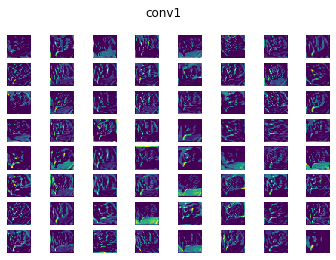

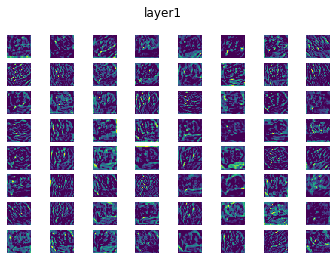

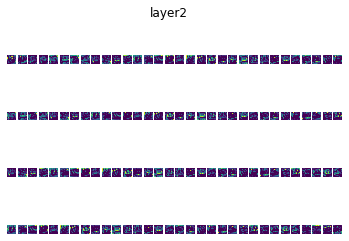

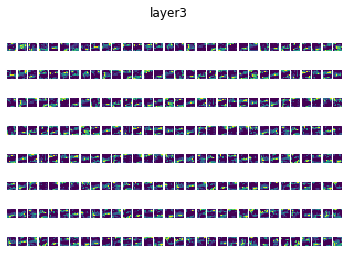

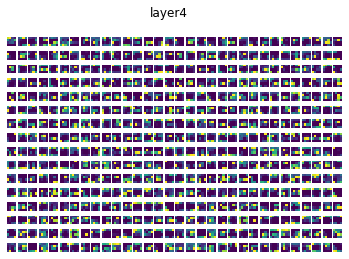

In [0]:
#!pip install matplotlib

import matplotlib.pyplot as plt

plt.tight_layout()


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

vis_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']

for l in vis_labels:

    getattr(model, l).register_forward_hook(get_activation(l))
    
    
data, _ = cifar10_test[0]
data = data.unsqueeze_(0).to(device = device, dtype = dtype)

output = model(data)



for idx, l in enumerate(vis_labels):

    act = activation[l].squeeze()

    if idx < 2:
        ncols = 8
    else:
        ncols = 32
        
    nrows = act.size(0) // ncols
    
    fig, axarr = plt.subplots(nrows, ncols)
    fig.suptitle(l)


    for i in range(nrows):
        for j in range(ncols):
            axarr[i, j].imshow(act[i * nrows + j].cpu())
            axarr[i, j].axis('off')